In [3]:
import sys;sys.path.append('..')
from ppanlp import *
ppa = PPA()

2023-12-06 15:21:39,935 [1] > booting PPACorpus at /home/rh6841/ppa_data/corpus
2023-12-06 15:21:39,936   [2] > reading metadata
2023-12-06 15:21:39,986   [2] < 0.05 seconds
2023-12-06 15:21:40,423 [1] < 0.49 seconds


In [86]:
from string import punctuation


class NERModel:
    def __init__(self, corpus=None):
        self.corpus = corpus if corpus is not None else PPA()
        self.ent2pages=defaultdict(set)
        self.ent2count=Counter()
        self._annodf=None
        
    @staticmethod
    def clean_ent(ent):
        o=ent.strip(punctuation).title()
        if o.endswith("'S"): o = o[:-2]
        return o
    
    @staticmethod
    def iter_by_page(iterr):
        last_pageid=None
        last_l=[]
        for res in iterr:
            pageid=res[0]
            if last_l and pageid!=last_pageid:
                yield (pageid,last_l)
                last_l=[]
            last_l.append(res[1:])
            last_pageid = pageid
        if last_l: yield last_l
        
    def iter_ents(self,ent_types:set=None,lim=None,by_page=False,ents=None):
        def iterr():
            with self.corpus.ents_db(flag='r') as db:
                total=len(db)
                iterr=tqdm(db.items(),desc='Iterating over saved ents',position=0,total=total)
                for page_id,page_ents in iterr:
                    for ent,ent_type in page_ents:
                        ent = self.clean_ent(ent)
                        if (not ent_types or ent_type in ent_types) and (not ents or ent in ents):
                            yield page_id,ent,ent_type
        oiterr = (self.iter_by_page(iterr()) if by_page else iterr())
        yield from iterlim(oiterr,lim)
    
                            
    def iter_persons(self, **kwargs):
        kwargs['ent_types']={'PERSON'}
        yield from self.iter_ents(**kwargs)
    
    def count_ents(self, **kwargs):
        self.ent2count=Counter()
        for res in self.iter_ents(**kwargs):
            page_id,ent = res[:2]
            self.ent2pages[ent].add(page_id)
            self.ent2count[ent]+=1
        self.ent2count_s = pd.Series(self.ent2count).sort_values(ascending=False)
        return self.ent2count_s
    
    def count_persons(self, **kwargs):
        kwargs['ent_types']={'PERSON'}
        return self.count_ents(**kwargs)
    
    def prep_anno_df(self, min_count=100):
        s = ner.ent2count_s
        s = s[s>=min_count]
        df = pd.DataFrame({'count':s}).rename_axis('name')
        df['is_valid'] = ''
        return df
    
    @cached_property
    def path_to_anno(self): return os.path.join(self.corpus.path_data, 'data.ner.to_anno.csv')
    @cached_property
    def path_anno(self): return os.path.join(self.corpus.path_data, 'data.ner.anno.csv')
    
    def load_anno_df(self, fn=None, force=False):
        if force or self._annodf is None:
            fn=fn if fn else self.path_anno
            self._annodf = pd.read_csv(fn).set_index('name').fillna('')
        return self._annodf
    
    @cached_property
    def anno_df(self): return self.load_anno_df()

    @cached_property
    def anno_ents(self): 
        df=self.anno_df
        df=df[df.is_valid.str.startswith('y')]
        return set(df.index)

    def iter_ents_anno(self, **kwargs):
        kwargs['ents']=self.anno_ents
        yield from self.iter_ents(**kwargs)

    def iter_persons_anno(self, **kwargs):
        kwargs['ent_types']={'PERSON'}
        yield from self.iter_ents_anno(**kwargs)

    def link_persons(self, min_page_count=2,**kwargs):
        import networkx as nx
        last_pageid=None
        last_ents = []
        G = nx.Graph()
        l = [x for x in self.iter_persons_anno(by_page=True) if len(x)==2]
        for pageid,page_ents in l:
            for a1,b1 in page_ents:
                for a2,b2 in page_ents:
                    if a1<a2:
                        if G.has_edge(a1,a2): 
                            G.edges[a1,a2]['weight']+=1
                        else: 
                            G.add_edge(a1,a2,weight=0)
        
        bad=[(a,b) for a,b,d in G.edges(data=True) if d['weight']<min_page_count]
        G.remove_edges_from(bad)
        return G
    
#     def person_cooccurence_matrix(self, min_page_count=2,**kwargs):
#         persons = defaultdict(Counter)
#         numpages = 0
#         for pagedata in self.iter_persons_anno(by_page=True):
#             if len(pagedata)!=2: continue 
#             numpages+=1
#             pageid,pageents = pagedata
#             pageents = {x[0] for x in pageents}
#             for x in pageents:
#                 for y in pageents:
#                     if x!=y:
#                         persons[x][y]+=1
#         df = pd.DataFrame(persons).fillna(0) / numpages * 1000
#         return df
        
    def person_cooccurence(self, min_page_count=5,**kwargs):
        person1 = Counter()
        person2 = Counter()
        numpages = 0
        for pagedata in self.iter_persons_anno(by_page=True):
            if len(pagedata)!=2: continue 
            numpages+=1
            pageid,pageents = pagedata
            pageents = {x[0] for x in pageents}
            for x in pageents:
                person1[x]+=1
                for y in pageents:
                    if x<y:
                        person2[x,y]+=1
        
        # calc probs
        person1_sum = sum(person1.values())
        person2_sum = sum(person2.values())
        person1_probs = {k:v/person1_sum for k,v in person1.items()}
        person2_probs = {k:v/person2_sum for k,v in person2.items()}

        o=[]
        for pair in tqdm(person2_probs):
            if min_page_count and person2[pair]<min_page_count: continue
            p1,p2 = pair
            p1_prob,p2_prob = person1_probs[p1],person1_probs[p2]
            prob_exp = p1_prob * p2_prob
            prob_obs = person2_probs[pair]
            od={
                'person1':p1, 'person2':p2, 
                'count1':person1[p1], 'count2':person1[p2], 'count_both':person2[pair],
                'prob1':p1_prob, 'prob2':p2_prob, 
                'prob_exp':prob_exp, 'prob_obs':prob_obs, 'prob_obs/exp':prob_obs/prob_exp
            }
            o.append(od)
        return pd.DataFrame(o).sort_values('prob_obs/exp',ascending=False)
            
            
            
        
            
                    
        

In [87]:
ner = NERModel(ppa)
# for d in ner.iter_persons_anno(by_page=True): break
# d

In [88]:
# G=ner.link_persons(min_page_count=10)

In [89]:
df = ner.person_cooccurence_matrix()
df

100%|██████████| 42933/42933 [00:00<00:00, 1930509.38it/s]


,person1,person2,count1,count2,count_both,prob1,prob2,prob_exp,prob_obs,prob_obs/exp
658,Juliet,Romeo,946,844,641,0.002457,0.002192,0.000005,0.001287,238.930340
3730,Cressida,Troilus,490,942,365,0.001273,0.002447,0.000003,0.000733,235.338368
1391,Chatterton,Rowley,547,424,136,0.001421,0.001101,0.000002,0.000273,174.514927
3529,Greene,Peele,885,494,239,0.002299,0.001283,0.000003,0.000480,162.695124
1898,Antony,Cleopatra,1110,846,459,0.002883,0.002197,0.000006,0.000921,145.467575
...,...,...,...,...,...,...,...,...,...,...
16538,Homer,Jesus,7738,1164,6,0.020097,0.003023,0.000061,0.000012,0.198251
12862,Chaucer,Jones,10164,1086,7,0.026398,0.002821,0.000074,0.000014,0.188734
15052,Virgil,Walker,6915,1485,6,0.017960,0.003857,0.000069,0.000012,0.173892
6619,Homer,Walker,7738,1485,5,0.020097,0.003857,0.000078,0.000010,0.129498


In [99]:
fdf=df[(df.count_both>=25) & (df['prob_obs/exp']>=10)]
fdf

,person1,person2,count1,count2,count_both,prob1,prob2,prob_exp,prob_obs,prob_obs/exp
658,Juliet,Romeo,946,844,641,0.002457,0.002192,0.000005,0.001287,238.930340
3730,Cressida,Troilus,490,942,365,0.001273,0.002447,0.000003,0.000733,235.338368
1391,Chatterton,Rowley,547,424,136,0.001421,0.001101,0.000002,0.000273,174.514927
3529,Greene,Peele,885,494,239,0.002299,0.001283,0.000003,0.000480,162.695124
1898,Antony,Cleopatra,1110,846,459,0.002883,0.002197,0.000006,0.000921,145.467575
...,...,...,...,...,...,...,...,...,...,...
2980,Goethe,Wagner,1779,466,28,0.004620,0.001210,0.000006,0.000056,10.051781
5305,Longfellow,Tennyson,1481,4099,205,0.003847,0.010646,0.000041,0.000412,10.050039
11316,Carlyle,Irving,1207,786,32,0.003135,0.002041,0.000006,0.000064,10.038458
12421,Browne,Cowper,763,1675,43,0.001982,0.004350,0.000009,0.000086,10.013271


In [100]:
import networkx as nx
G=nx.Graph()
for p1,p2,w in zip(fdf.person1,fdf.person2,fdf['prob_obs/exp']):
    if w>1:
        G.add_edge(p1,p2,weight=w)
G.order(), G.size()

(315, 1034)

In [101]:
from pyvis.network import Network
nt = Network(notebook=True, cdn_resources='in_line')

In [102]:
nt.from_nx(G)
nt.show('nx.html')

nx.html


In [ ]:
G.order(), G.size()

In [85]:
d1=nx.degree_centrality(G)
d2=nx.betweenness_centrality(G)
df = pd.DataFrame({'degree':d1, 'betweenness':d2})
df

,degree,betweenness
Collins,0.648045,0.001650
Sterne,0.483240,0.000672
Alexander,0.882682,0.006169
Darius,0.175978,0.000113
Cicero,0.840782,0.005101
...,...,...
Shelley'S,0.220670,0.000135
Crist,0.100559,0.000101
Wordsworth'S,0.251397,0.000118
Layamon,0.231844,0.000239


In [89]:
df.sort_values('betweenness',ascending=False).head(10)

,degree,betweenness
Milton,0.997207,0.009186
Chaucer,0.986034,0.008962
Dryden,0.983240,0.008887
Shakespeare,0.988827,0.008825
Pope,0.974860,0.008361
Homer,0.969274,0.008079
Spenser,0.963687,0.007836
Johnson,0.958101,0.007631
Virgil,0.938547,0.007191
Horace,0.932961,0.007094


In [90]:
df.sort_values('degree',ascending=False).head(10)

,degree,betweenness
Milton,0.997207,0.009186
Shakespeare,0.988827,0.008825
Chaucer,0.986034,0.008962
Dryden,0.983240,0.008887
Pope,0.974860,0.008361
Homer,0.969274,0.008079
Spenser,0.963687,0.007836
Johnson,0.958101,0.007631
Virgil,0.938547,0.007191
Horace,0.932961,0.007094


<Axes: xlabel='degree', ylabel='betweenness'>

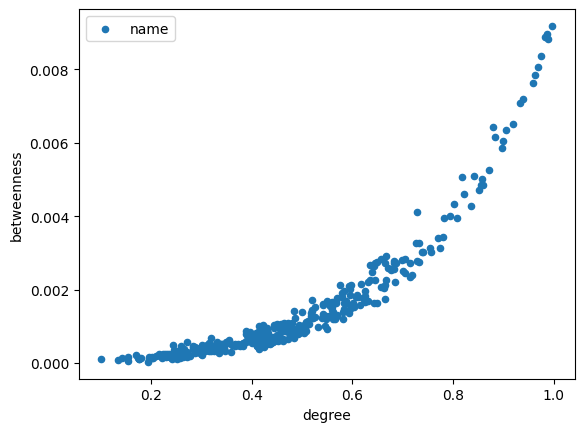

In [99]:
df.rename_axis('name').reset_index().plot(x='degree',y='betweenness',kind='scatter',label='name')